In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('/kaggle/input/early-diabetes-classification/diabetes_data.csv', delimiter=";")


NameError: name 'pd' is not defined

In [4]:
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [5]:
df.select_dtypes(include=['object']).columns

Index(['gender'], dtype='object')

In [6]:
df.select_dtypes(include=['int','float']).columns

Index(['age', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness',
       'polyphagia', 'genital_thrush', 'visual_blurring', 'itching',
       'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity', 'class'],
      dtype='object')

In [7]:
(df.isna().sum()/df.isna().count() * 100).sort_values(ascending= False).head(25)

age                   0.0
itching               0.0
obesity               0.0
alopecia              0.0
muscle_stiffness      0.0
partial_paresis       0.0
delayed_healing       0.0
irritability          0.0
visual_blurring       0.0
gender                0.0
genital_thrush        0.0
polyphagia            0.0
weakness              0.0
sudden_weight_loss    0.0
polydipsia            0.0
polyuria              0.0
class                 0.0
dtype: float64

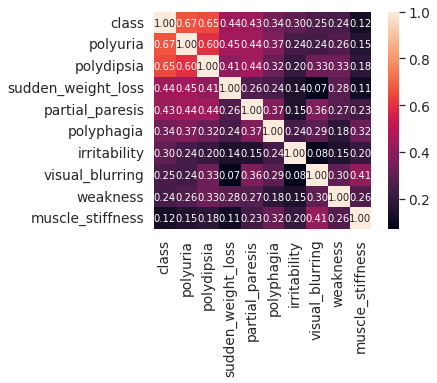

In [8]:
corrmat = df.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'class')['class'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
category_features = ['gender']

numeric_features = ['age', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness',
       'polyphagia', 'genital_thrush', 'visual_blurring', 'itching',
       'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity']

target = ['class']

In [10]:
print('category feature number = ', len(category_features))
print('numeric feature number = ', len(numeric_features))

category feature number =  1
numeric feature number =  15


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], test_size = 0.2, random_state= 14)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
numeric_transformer = Pipeline(steps =[('imputer_numeric', SimpleImputer(missing_values=np.nan, strategy='mean')),
                                       ('scaler', StandardScaler())])

In [15]:
category_transformer = Pipeline(steps=[('imputer_category', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('category_transformer', category_transformer, category_features),
        ('numeric_transfomer', numeric_transformer, numeric_features)
    ], remainder='drop'
)

In [17]:
import optuna
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [18]:
# pipeline_rf = make_pipeline(clone(preprocessor), RandomForestClassifier())
pipeline_rf = make_pipeline(clone(preprocessor), XGBClassifier())

In [19]:
def objective(trail):
#     parameter for the random forest classfication    
#     params = {
#         'randomforestclassifier__n_estimators': trail.suggest_int('randomforestclassifier__n_estimators', 10, 20, log=True),
#         'randomforestclassifier__max_depth': trail.suggest_int("randomforestclassifier__max_depth", 3, 10, log=True) ,
#         'randomforestclassifier__max_features': trail.suggest_categorical('randomforestclassifier__max_features', ['auto', 'sqrt']),
#         'randomforestclassifier__min_samples_split': trail.suggest_int("randomforestclassifier__min_samples_split", 2, 10, log=True) ,
#         'randomforestclassifier__min_samples_leaf': trail.suggest_int("randomforestclassifier__min_samples_leaf", 1, 4, log=True),
#         'randomforestclassifier__bootstrap': trail.suggest_categorical('randomforestclassifier__bootstrap', [True, False])
#     }
    
    #parameter for the xgboost regressor
    params = {
        'xgbclassifier__n_estimators': trail.suggest_int('xgbclassifier__n_estimators', 10, 20, log=True),
        'xgbclassifier__max_depth': trail.suggest_int("xgbclassifier__max_depth", 3, 20, log=True) ,
        'xgbclassifier__eta': trail.suggest_float('xgbclassifier__eta', 0.1, 0.3, log=True),
        'xgbclassifier__subsample': trail.suggest_float("xgbclassifier__subsample", 0.4, 0.8, log=True) ,
        'xgbclassifier__colsample_bytree': trail.suggest_float("xgbclassifier__colsample_bytree", 0.4, 0.8, log=True),
    }
    
    model = pipeline_rf.set_params(**params)
    model.fit(X_train, y_train)
    
    
    score = cross_val_score(model, X_train, y_train, scoring = 'f1', n_jobs = -1, cv = 3).mean()
    
    return score

In [20]:
pipeline_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__category_transformer', 'columntransformer__numeric_transfomer', 'columntransformer__category_transformer__memory', 'columntransformer__category_transformer__steps', 'columntransformer__category_transformer__verbose', 'columntransformer__category_transformer__imputer_category', 'columntransformer__category_transformer__onehot', 'columntransformer__category_transformer__imputer_category__add_indicator', 'columntransformer__category_transformer__imputer_category__copy', 'columntransformer__category_transformer__imputer_category__fill_value', 'columntransformer__category_transformer__imputer_category__missing_values', 'columntransformer__cate

In [21]:
study_rfr = optuna.create_study(direction = "maximize")
study_rfr.optimize(objective, n_trials = 10)

[I 2022-03-06 02:22:08,785] A new study created in memory with name: no-name-615b52ee-e966-415e-81e3-822fc547a7b9


[02:22:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2022-03-06 02:22:1

[02:22:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:20,510] Trial 1 finished with value: 0.9429842223455701 and parameters: {'xgbclassifier__n_estimators': 12, 'xgbclassifier__max_depth': 17, 'xgbclassifier__eta': 0.14543864243368218, 'xgbclassifier__subsample': 0.6109708969158554, 'xgbclassifier__colsample_bytree': 0.5216574447799074}. Best is trial 1 with value: 0.9429842223455701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

[02:22:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:26,964] Trial 2 finished with value: 0.9404666641263066 and parameters: {'xgbclassifier__n_estimators': 19, 'xgbclassifier__max_depth': 3, 'xgbclassifier__eta': 0.12756712488940244, 'xgbclassifier__subsample': 0.5400640922364974, 'xgbclassifier__colsample_bytree': 0.4804341805862643}. Best is trial 1 with value: 0.9429842223455701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[02:22:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:36,571] Trial 3 finished with value: 0.9489173175051363 and parameters: {'xgbclassifier__n_estimators': 18, 'xgbclassifier__max_depth': 12, 'xgbclassifier__eta': 0.12896252278266052, 'xgbclassifier__subsample': 0.572805638297615, 'xgbclassifier__colsample_bytree': 0.40713345625247593}. Best is trial 3 with value: 0.9489173175051363.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

[02:22:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:43,418] Trial 4 finished with value: 0.941037801132577 and parameters: {'xgbclassifier__n_estimators': 18, 'xgbclassifier__max_depth': 16, 'xgbclassifier__eta': 0.10050412877482119, 'xgbclassifier__subsample': 0.41299964760734725, 'xgbclassifier__colsample_bytree': 0.5116426489388105}. Best is trial 3 with value: 0.9489173175051363.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

[02:22:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:48,122] Trial 5 finished with value: 0.9495083362686393 and parameters: {'xgbclassifier__n_estimators': 11, 'xgbclassifier__max_depth': 6, 'xgbclassifier__eta': 0.16894061970913948, 'xgbclassifier__subsample': 0.7120669760118938, 'xgbclassifier__colsample_bytree': 0.6186209275285933}. Best is trial 5 with value: 0.9495083362686393.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[02:22:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:22:53,628] Trial 6 finished with value: 0.943311160384331 and parameters: {'xgbclassifier__n_estimators': 10, 'xgbclassifier__max_depth': 13, 'xgbclassifier__eta': 0.2920322854219043, 'xgbclassifier__subsample': 0.4392357616489895, 'xgbclassifier__colsample_bytree': 0.4678634135950527}. Best is trial 5 with value: 0.9495083362686393.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

[02:22:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:23:01,964] Trial 7 finished with value: 0.9372420802566644 and parameters: {'xgbclassifier__n_estimators': 19, 'xgbclassifier__max_depth': 16, 'xgbclassifier__eta': 0.1912873498247978, 'xgbclassifier__subsample': 0.42070914724538094, 'xgbclassifier__colsample_bytree': 0.6297430832272273}. Best is trial 5 with value: 0.9495083362686393.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

[02:23:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:23:08,051] Trial 8 finished with value: 0.9471284746310932 and parameters: {'xgbclassifier__n_estimators': 16, 'xgbclassifier__max_depth': 6, 'xgbclassifier__eta': 0.1191746896971995, 'xgbclassifier__subsample': 0.5994749889134076, 'xgbclassifier__colsample_bytree': 0.6777422974407031}. Best is trial 5 with value: 0.9495083362686393.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

[02:23:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-06 02:23:15,372] Trial 9 finished with value: 0.9513628735346903 and parameters: {'xgbclassifier__n_estimators': 14, 'xgbclassifier__max_depth': 16, 'xgbclassifier__eta': 0.10151516778192593, 'xgbclassifier__subsample': 0.5998799664505702, 'xgbclassifier__colsample_bytree': 0.42987132183567195}. Best is trial 9 with value: 0.9513628735346903.


In [22]:
print(study_rfr.best_trial)

FrozenTrial(number=9, values=[0.9513628735346903], datetime_start=datetime.datetime(2022, 3, 6, 2, 23, 8, 53155), datetime_complete=datetime.datetime(2022, 3, 6, 2, 23, 15, 371633), params={'xgbclassifier__n_estimators': 14, 'xgbclassifier__max_depth': 16, 'xgbclassifier__eta': 0.10151516778192593, 'xgbclassifier__subsample': 0.5998799664505702, 'xgbclassifier__colsample_bytree': 0.42987132183567195}, distributions={'xgbclassifier__n_estimators': IntLogUniformDistribution(high=20, low=10, step=1), 'xgbclassifier__max_depth': IntLogUniformDistribution(high=20, low=3, step=1), 'xgbclassifier__eta': LogUniformDistribution(high=0.3, low=0.1), 'xgbclassifier__subsample': LogUniformDistribution(high=0.8, low=0.4), 'xgbclassifier__colsample_bytree': LogUniformDistribution(high=0.8, low=0.4)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE, value=None)


In [23]:
print(study_rfr.best_params)

{'xgbclassifier__n_estimators': 14, 'xgbclassifier__max_depth': 16, 'xgbclassifier__eta': 0.10151516778192593, 'xgbclassifier__subsample': 0.5998799664505702, 'xgbclassifier__colsample_bytree': 0.42987132183567195}


In [24]:
print(study_rfr.best_value)

0.9513628735346903


In [25]:
pipeline_rf.set_params(**study_rfr.best_params)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category_transformer',
                                                  Pipeline(steps=[('imputer_category',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                  

In [26]:
pipeline_rf.fit(X_train, y_train)

[02:23:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category_transformer',
                                                  Pipeline(steps=[('imputer_category',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                  

In [27]:
y_train_pred = pipeline_rf.predict(X_train)
y_test_pred = pipeline_rf.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))

[[161   5]
 [  7 243]]
[[32  2]
 [ 5 65]]


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       166
           1       0.98      0.97      0.98       250

    accuracy                           0.97       416
   macro avg       0.97      0.97      0.97       416
weighted avg       0.97      0.97      0.97       416

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.97      0.93      0.95        70

    accuracy                           0.93       104
   macro avg       0.92      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104



In [30]:
from sklearn import set_config
set_config(display="diagram")
pipeline_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category_transformer',
                                                  Pipeline(steps=[('imputer_category',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'poly...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.212328777, max_delta_step=0,
                               max_depth=16, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=14,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.5998799664505702,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [31]:
pipeline_rf.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('category_transformer',
                                    Pipeline(steps=[('imputer_category',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['gender']),
                                   ('numeric_transfomer',
                                    Pipeline(steps=[('imputer_numeric',
                                                     SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'polyuria', 'polydipsia',
                                     'sudden_weight_loss', 'weakness',
                                     'polyphagia', 'genital_thrush',
                   

In [32]:
preprocessor.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('category_transformer',
   Pipeline(steps=[('imputer_category', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
   ['gender']),
  ('numeric_transfomer',
   Pipeline(steps=[('imputer_numeric', SimpleImputer()),
                   ('scaler', StandardScaler())]),
   ['age',
    'polyuria',
    'polydipsia',
    'sudden_weight_loss',
    'weakness',
    'polyphagia',
    'genital_thrush',
    'visual_blurring',
    'itching',
    'irritability',
    'delayed_healing',
    'partial_paresis',
    'muscle_stiffness',
    'alopecia',
    'obesity'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'category_transformer': Pipeline(steps=[('imputer_category', SimpleImputer(strategy='most_frequent')),
                 ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
 'numeric_transfomer': Pipeline(steps=[

In [33]:
pipeline_rf.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category_transformer',
                                                  Pipeline(steps=[('imputer_category',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   Standar